<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Estimation_of_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 2.5 MB/s 


In [2]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, r_regression, SelectPercentile, mutual_info_regression, SequentialFeatureSelector as SFS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import RepeatedKFold

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

In [3]:
#@title Load RoI data
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
roi['eta'] = roi['TSigma']*155 / roi['TAmp']

In [4]:
#@title One Feature Fit Function

def onefeat(roi, feature, xmin, xmax):

  fig, (ax) = plt.subplots(1,2, figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k', gridspec_kw={'width_ratios': [2, 1]}) 

  # Background
  box = ax[0].boxplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')

  violin = ax[0].violinplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='darkgray', alpha=1)

  # Source Data
  data = []
  for d in [5,10,15,20,25,30,35,40,45]:
      data.append(np.array(roi[feature].loc[roi['z[cm]']==d]))

  box = ax[0].boxplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')
  violin = ax[0].violinplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='tab:orange', alpha=1)

  # Plot Settings
  ax[0].set_ylim(-2.5,50)

  ax[0].set_xlim(xmin, xmax)
  ax[0].spines["right"].set_visible(False)
  ax[0].spines["top"].set_visible(False)
  ax[0].set_xlabel(feature, y=0.5, ha='center', fontsize=22)
  ax[0].tick_params(axis='both', which='both', labelsize=22)
  ax[0].set_ylabel('Interaction Depth, $z$ [cm]', x=0.5, ha='center', fontsize=22)

  # Linear fit (1st order)
  Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
  X = roi[[feature]].loc[roi['z[cm]']>=4]

  r2 = []
  RMSE = []
  MAE = []
  m = []
  b = []


  rkf = RepeatedKFold(n_splits=10, n_repeats=50, random_state=0)
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf = LinearRegression().fit(X_train, y_train)
    preds = clf.predict(X_test)

    m.append(clf.coef_)
    b.append(clf.intercept_)
    r2.append(r2_score(y_test, preds))
    RMSE.append(np.sqrt(mean_squared_error(y_test, preds)))
    MAE.append(mean_absolute_error(y_test, preds))

  print('MODEL SUMMARY:')
  print('Cofficient: ', ufloat(np.mean(m), 3*np.std(m)))
  print('Intercept: ', ufloat(np.mean(b), 3*np.std(b)))
  print('r2 = ', ufloat(np.mean(r2), 3*np.std(r2)))
  print('RMSE = ', ufloat(np.mean(RMSE), 3*np.std(RMSE)))
  print('MAE = ', ufloat(np.mean(MAE), 3*np.std(MAE)))

  #predictions = model.get_prediction(xnew)
  #frame = predictions.summary_frame(alpha=0.05)
  #ax[0].fill_between(x, frame.obs_ci_lower, frame.obs_ci_upper, alpha=0.2, color='tab:blue', zorder=1)

  ax[0].plot(np.arange(xmin,xmax, 0.1), clf.predict(np.arange(xmin,xmax, 0.1).reshape(-1,1)), color='tab:blue')

  residuals = y_test-preds
  ax[1].hist(residuals, bins=50, color='tab:orange')
  ax[1].axvline(x=0, color='k', ls='--', lw=1.5)
  ax[1].spines["right"].set_visible(False)
  ax[1].spines["top"].set_visible(False)
  ax[1].set_xlabel('Residuals [cm]', y=0.5, ha='center', fontsize=22)
  ax[1].tick_params(axis='both', which='both', labelsize=22)
  ax[1].set_ylabel('Counts [-]', x=0.5, ha='center', fontsize=22)

  plt.show()

# Transverse Profile, $\eta$

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  25.57+/-0.21
Intercept:  6.92+/-0.14
r2 =  0.170+/-0.016
RMSE =  11.25+/-0.14
MAE =  9.36+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


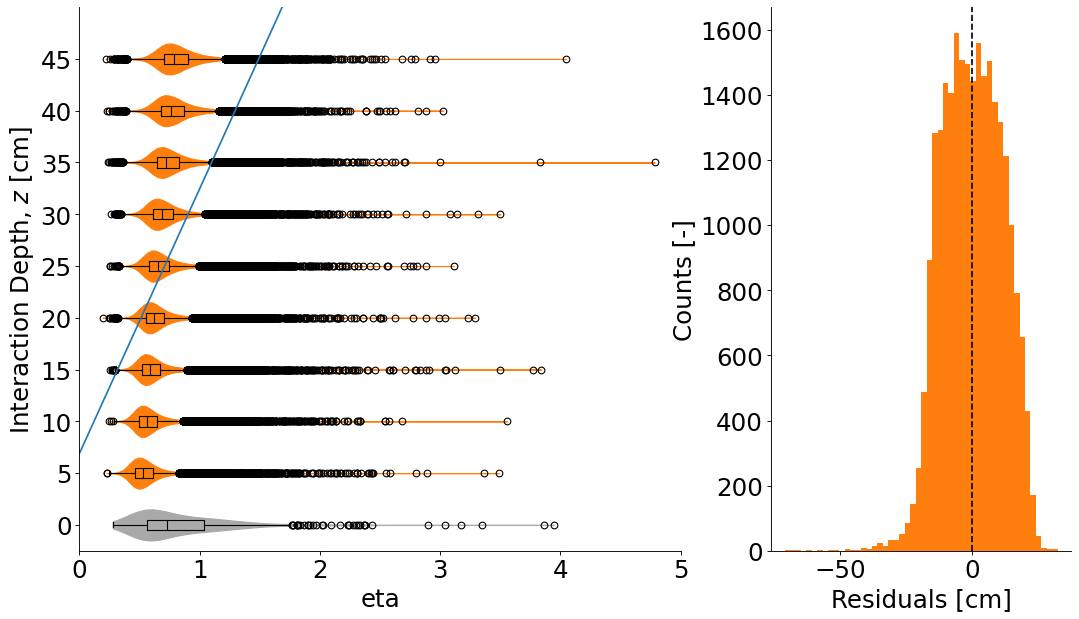

In [5]:
feature = 'eta' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax = 5 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

# Feature Selection

In [121]:
Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop('z[cm]', axis=1).loc[roi['z[cm]']>=4]

## Filter Methods

## Basic Methods

In [122]:
#@title Removal of constant and quasi-constant features
#@markdown The cluster Slimness, Pathlength, TStatus, LStatus, Person coefficient and Energy do not provide any information to the dataset.

#@markdown They will be removed from further analysis.
constant = []
print('Constant Features and how many times they were selected:')
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = VarianceThreshold( threshold=0.01)
  sel.fit(X_train) 
  for feature in [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]:
    constant.append(feature)
for feature in set(constant):
  print(feature, constant.count(feature))
X=X.drop(set(constant), axis=1)
print('Selected columns:', X.columns)

Constant Features and how many times they were selected:
LStatus 100
Energy 100
TStatus 100
Pearson 100
PathLen 100
Slim 100
Selected columns: Index(['Id', 'Hits', 'Integral', 'Length', 'Width', 'CorrIntegral', 'xMax',
       'xMin', 'yMax', 'yMin', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM',
       'Theta', 'TMean', 'TAmp', 'TRMS', 'Size', 'RMS', 'Short_RMS', 'LChi2',
       'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp', 'MFWHM', 'MMean',
       'MProm', 'Pixel', 'eta'],
      dtype='object')


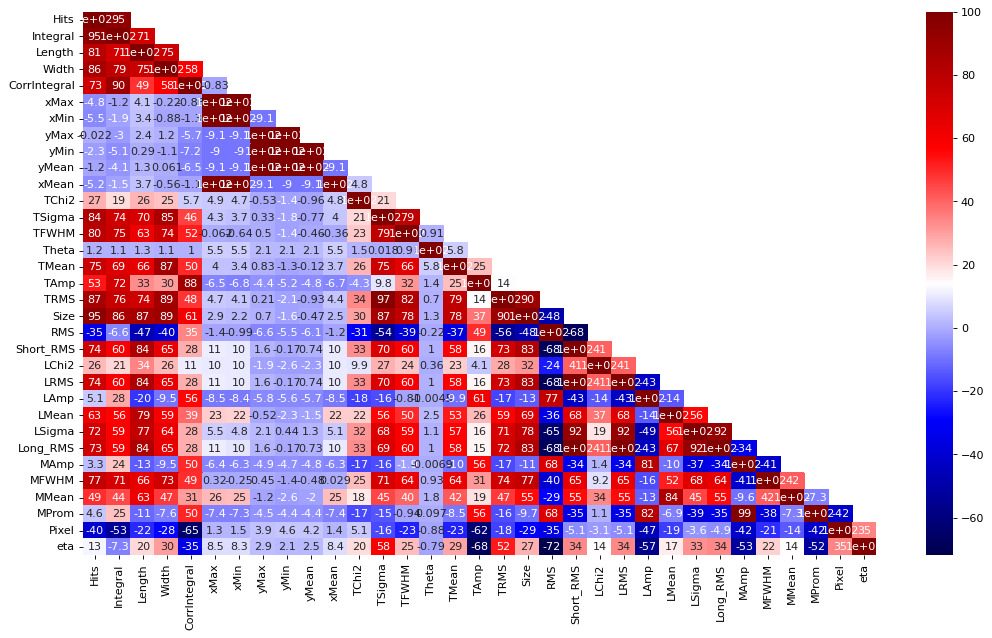

Hits and ['Integral' 'Width' 'TRMS' 'Size']
Integral and ['Hits' 'CorrIntegral' 'Size']
Length and ['Size']
Width and ['Hits' 'TMean' 'TRMS' 'Size']
CorrIntegral and ['Integral' 'TAmp']
xMax and ['xMin' 'xMean']
xMin and ['xMax' 'xMean']
yMax and ['yMin' 'yMean']
yMin and ['yMax' 'yMean']
yMean and ['yMax' 'yMin']
xMean and ['xMax' 'xMin']
TSigma and ['TRMS' 'Size']
TMean and ['Width']
TAmp and ['CorrIntegral']
TRMS and ['Hits' 'Width' 'TSigma' 'Size']
Size and ['Hits' 'Integral' 'Length' 'Width' 'TSigma' 'TRMS']
Short_RMS and ['LRMS' 'LSigma' 'Long_RMS']
LRMS and ['Short_RMS' 'LSigma' 'Long_RMS']
LSigma and ['Short_RMS' 'LRMS' 'Long_RMS']
Long_RMS and ['Short_RMS' 'LRMS' 'LSigma']
MAmp and ['MProm']
MProm and ['MAmp']


'----------------------------------------------------------------------------------------------------'

Features Correlation to the outcome:
z[cm]        1.000000
Hits         0.721759
Length       0.637626
Width        0.656132
TSigma       0.743639
TFWHM        0.650556
TRMS         0.763495
Size         0.736296
Short_RMS    0.708162
LRMS         0.708162
LSigma       0.707214
Long_RMS     0.706115
MFWHM        0.657159
Name: z[cm], dtype: float64
Remaining columns Index(['Id', 'CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM',
       'Theta', 'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM',
       'MMean', 'Pixel', 'eta'],
      dtype='object')


In [123]:
#@title Correlation Coefficients
corr = X.corr()
upper = corr.where(np.tril(np.ones(corr.shape), k=1).astype(bool))
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 
sns.heatmap(upper*100, annot=True, cmap='seismic')
plt.show()

to_drop = [column for column in corr.columns if any(np.abs(corr[column]) >= 0.9)]
for feature in to_drop:
  corr_feat = np.asarray(corr.loc[(corr[feature] >= 0.85)].index)
  if len(corr_feat) > 1:
    print(feature, 'and', corr_feat[corr_feat!=feature])

display('-'*100)
print('Features Correlation to the outcome:')
z_corr = roi.drop(['TStatus', 'Pearson', 'LStatus', 'PathLen', 'Slim', 'Energy'], axis=1).corr()[['z[cm]']]
print(z_corr['z[cm]'].loc[np.abs(z_corr['z[cm]'])>=0.6])

X=X.drop(['xMax', 'xMin', 'yMax', 'yMin', 'MProm', 'Short_RMS', 'Long_RMS', 'LRMS', 'Integral', 'Hits', 'Size', 'TRMS', 'TAmp', 'Length', 'Width', 'TMean'], axis=1)
print('Remaining columns', X.columns)

## Statistical tests

In [124]:
#@title Select 5 Best using F_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
p = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(f_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
  display('-'*100)

TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

In [125]:
#@title Select 5 Best using r_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(r_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'R-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t r-score :', ufloat(df['R-Score'].loc[df['Feature']==feature].mean(), df['R-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['R-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [103]:
#@title Select 5 Best using mutual_info_regression
#@markdown I selected 5 features

X.drop(['Id'], axis=1)

rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(mutual_info_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'Info-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t score :', ufloat(df['Info-Score'].loc[df['Feature']==feature].mean(), df['Info-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['Info-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

KeyboardInterrupt: ignored

## Wrapper Methods

In [ ]:
#@title Forward Selection using Linear Regression
#@markdown I selected up to 10 features.
print('Features with highest score and how many times they were selected:')
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = []
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=10)
  sfs.fit(X_train, y_train)
  for feature in [x for x in X_train.columns if x in X_train.columns[sfs.get_support()]]:
    selected.append(feature)
for feature in set(selected):
  print(feature, selected.count(feature))
display('-'*100)

Features with highest score and how many times they were selected:


KeyboardInterrupt: ignored

## One Feature Models

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  10.362+/-0.022
Intercept:  -26.89+/-0.11
r2 =  0.560+/-0.015
Max error =  48+/-4
MAE =  6.25+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


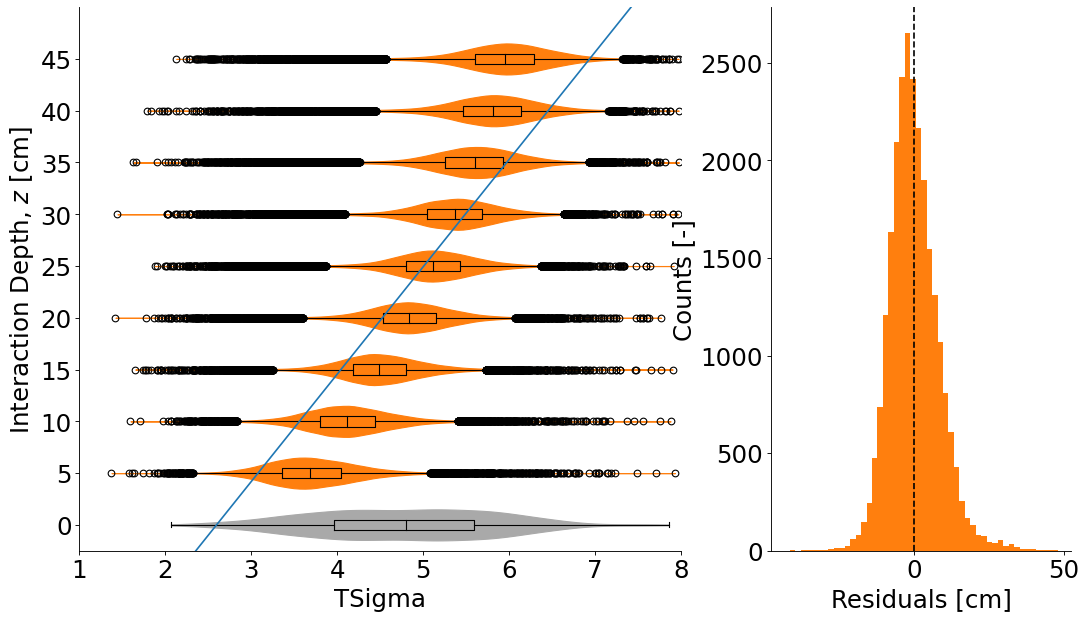

In [ ]:
feature = 'TSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1#@param {type:"number"}
xmax =  8#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  10.362+/-0.022
Intercept:  -26.89+/-0.11
r2 =  0.560+/-0.015
Max error =  48+/-4
MAE =  6.25+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


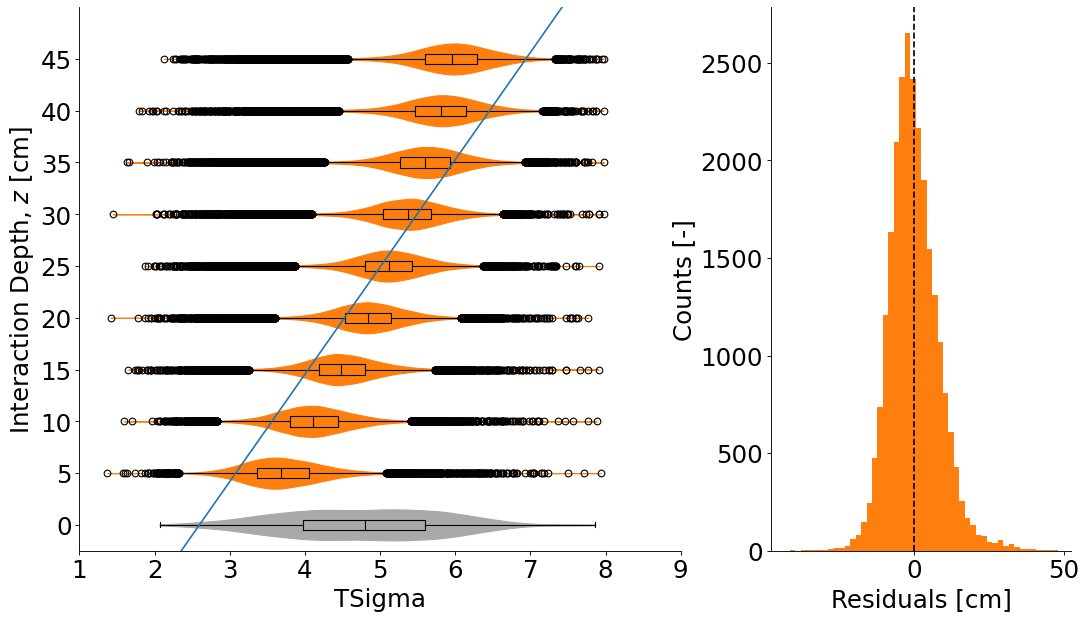

In [ ]:
feature = 'TSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1#@param {type:"number"}
xmax =  9#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  0.04836+/-0.00009
Intercept:  -13.15+/-0.08
r2 =  0.548+/-0.014
Max error =  45+/-8
MAE =  6.40+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


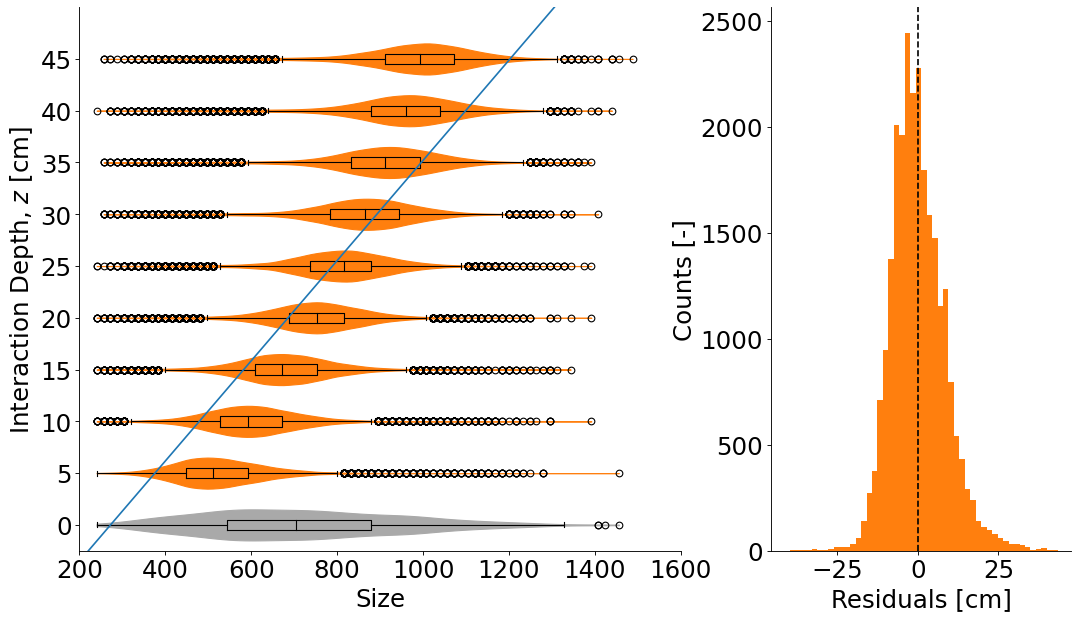

In [ ]:
feature = 'Size' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  200#@param {type:"number"}
xmax =  1600#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  0.08105+/-0.00016
Intercept:  -8.52+/-0.07
r2 =  0.526+/-0.016
Max error =  45+/-6
MAE =  6.54+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


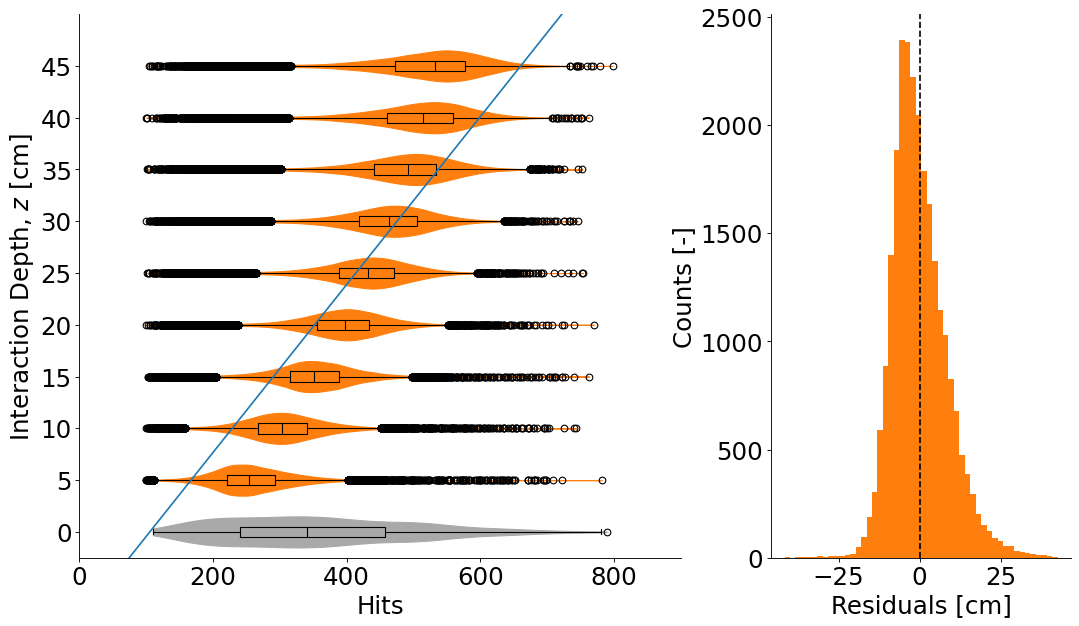

In [ ]:
feature = 'Hits' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax =  900#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  9.669+/-0.018
Intercept:  -32.23+/-0.10
r2 =  0.512+/-0.013
Max error =  47+/-5
MAE =  6.79+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


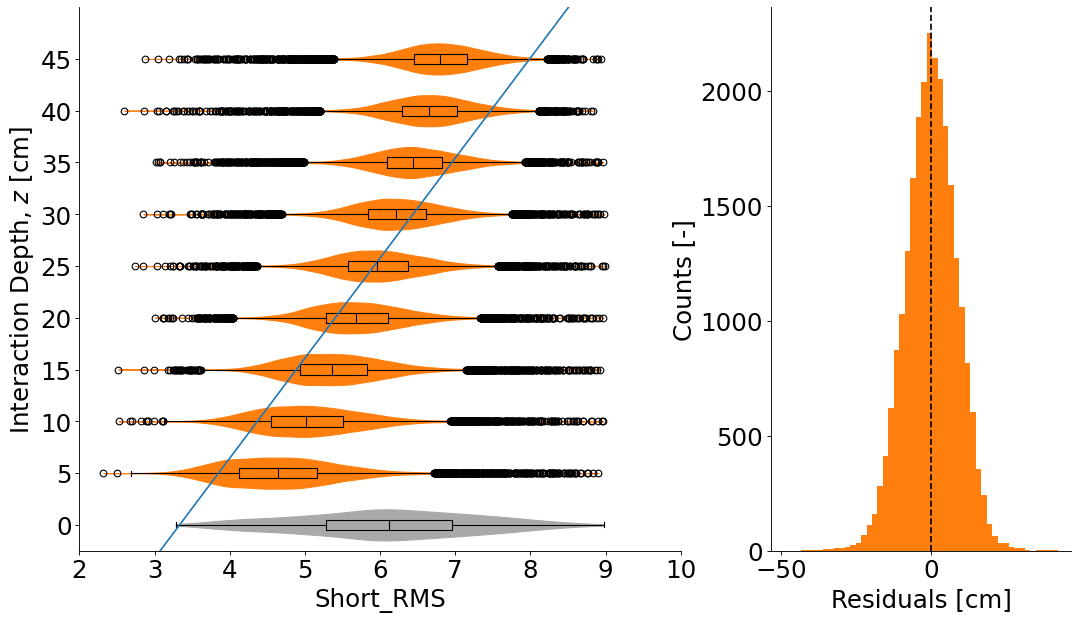

In [ ]:
feature = 'Short_RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  10#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  9.669+/-0.018
Intercept:  -32.23+/-0.10
r2 =  0.512+/-0.013
Max error =  47+/-5
MAE =  6.79+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


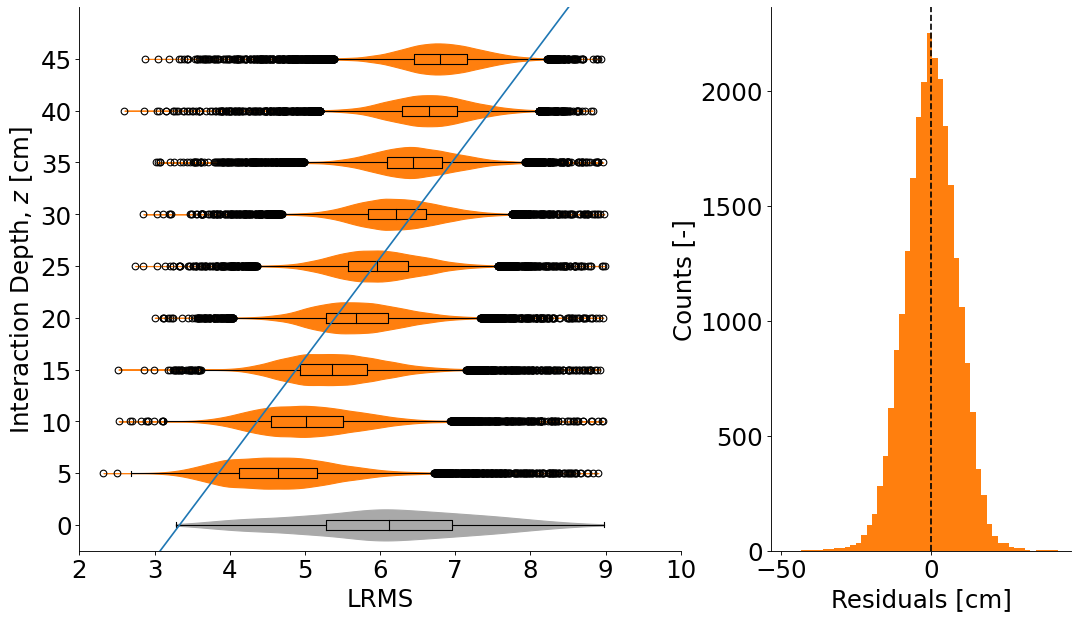

In [ ]:
feature = 'LRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  10#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  8.158+/-0.015
Intercept:  -25.86+/-0.09
r2 =  0.511+/-0.013
Max error =  48+/-7
MAE =  6.80+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


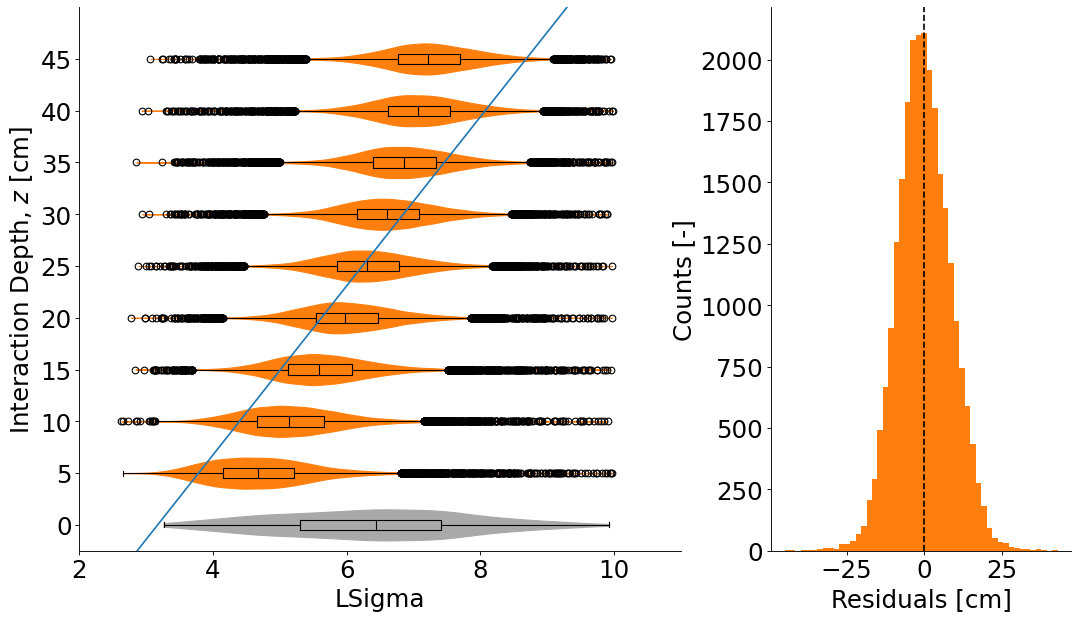

In [ ]:
feature = 'LSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  11#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  9.623+/-0.018
Intercept:  -32.08+/-0.10
r2 =  0.509+/-0.013
Max error =  47+/-4
MAE =  6.81+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


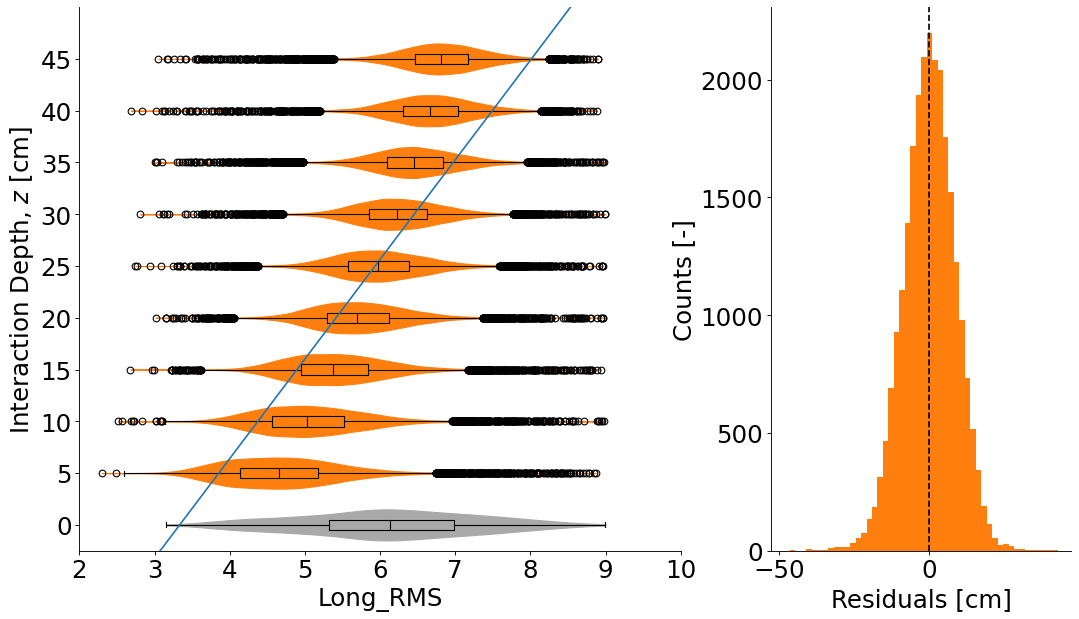

In [ ]:
feature = 'Long_RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  10#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  4.711+/-0.010
Intercept:  -1.79+/-0.06
r2 =  0.437+/-0.015
Max error =  40+/-8
MAE =  7.43+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


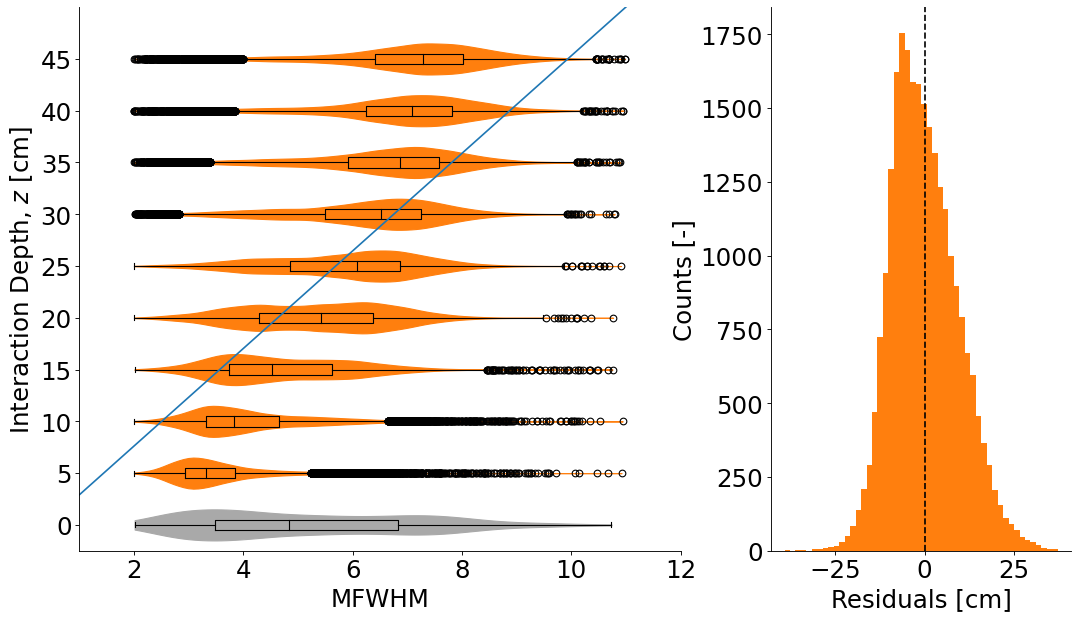

In [ ]:
feature = 'MFWHM' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1#@param {type:"number"}
xmax =  12#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  1.699+/-0.004
Intercept:  -28.99+/-0.13
r2 =  0.435+/-0.015
Max error =  45+/-6
MAE =  7.38+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


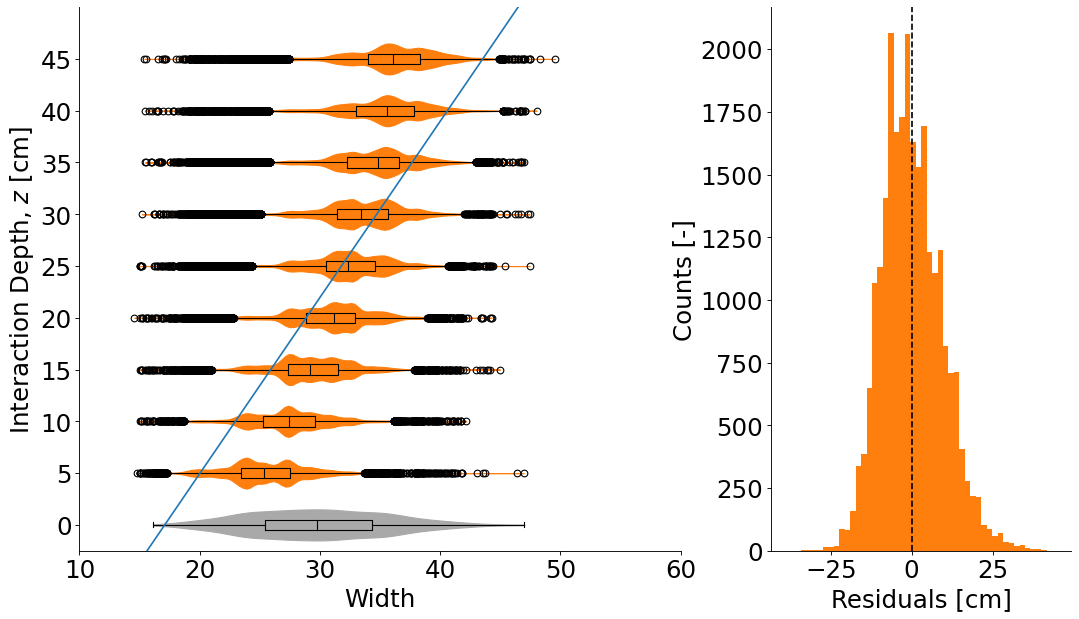

In [ ]:
feature = 'Width' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  10#@param {type:"number"}
xmax =  60#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  6.541+/-0.017
Intercept:  -13.77+/-0.11
r2 =  0.428+/-0.016
Max error =  45.3+/-3.2
MAE =  7.42+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


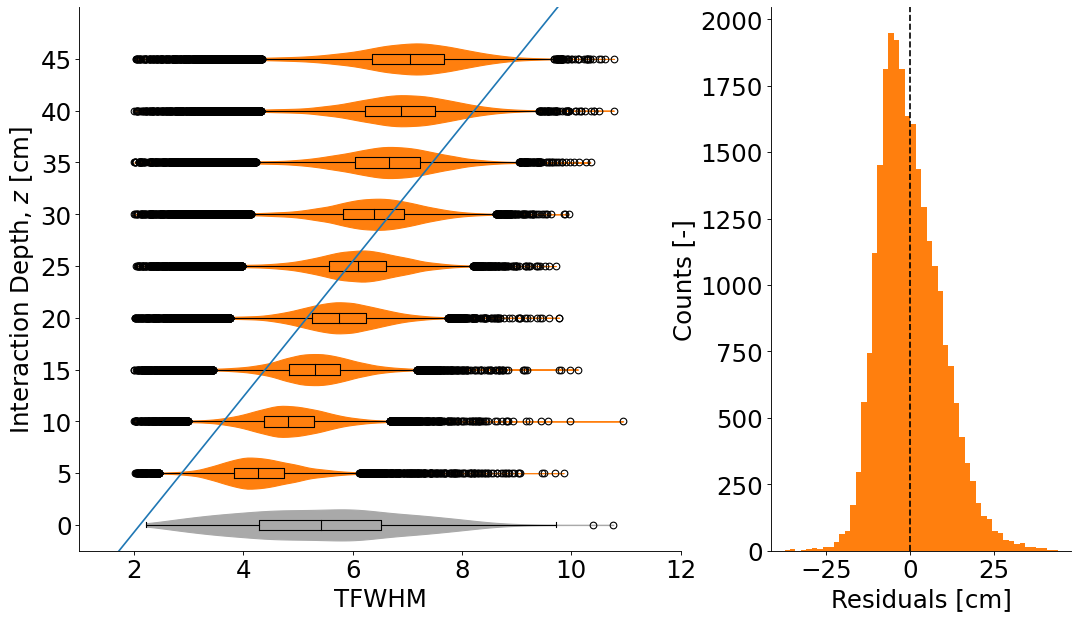

In [ ]:
feature = 'TFWHM' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1#@param {type:"number"}
xmax =  12#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  1.599+/-0.004
Intercept:  -35.55+/-0.13
r2 =  0.412+/-0.013
Max error =  43+/-5
MAE =  7.58+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


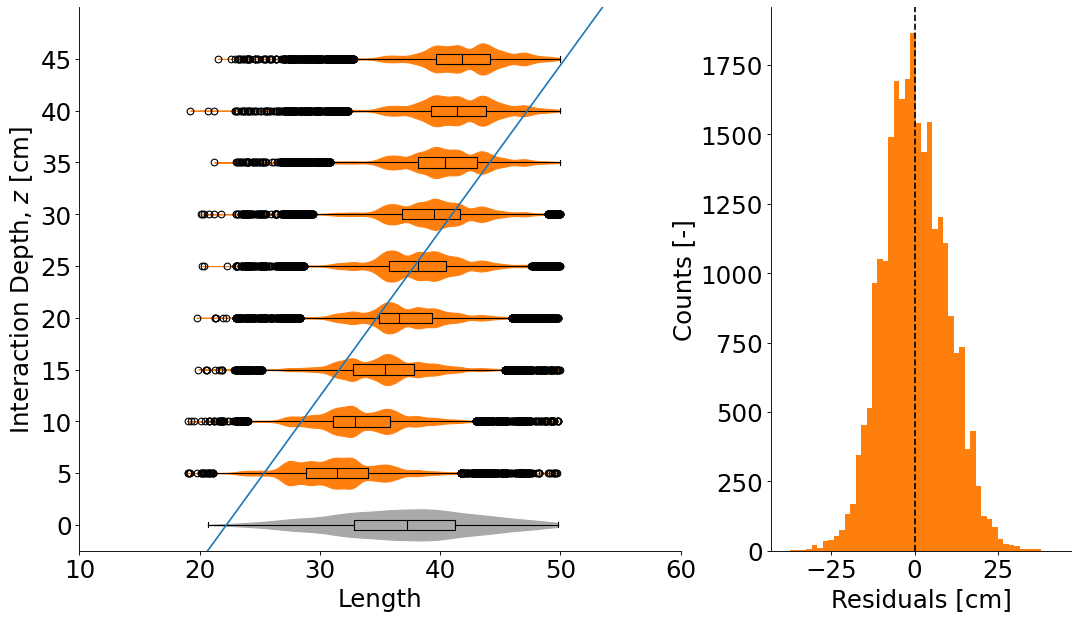

In [ ]:
feature = 'Length' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  10#@param {type:"number"}
xmax =  60#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  0.004026+/-0.000012
Intercept:  -5.28+/-0.09
r2 =  0.356+/-0.016
Max error =  44+/-6
MAE =  8.00+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


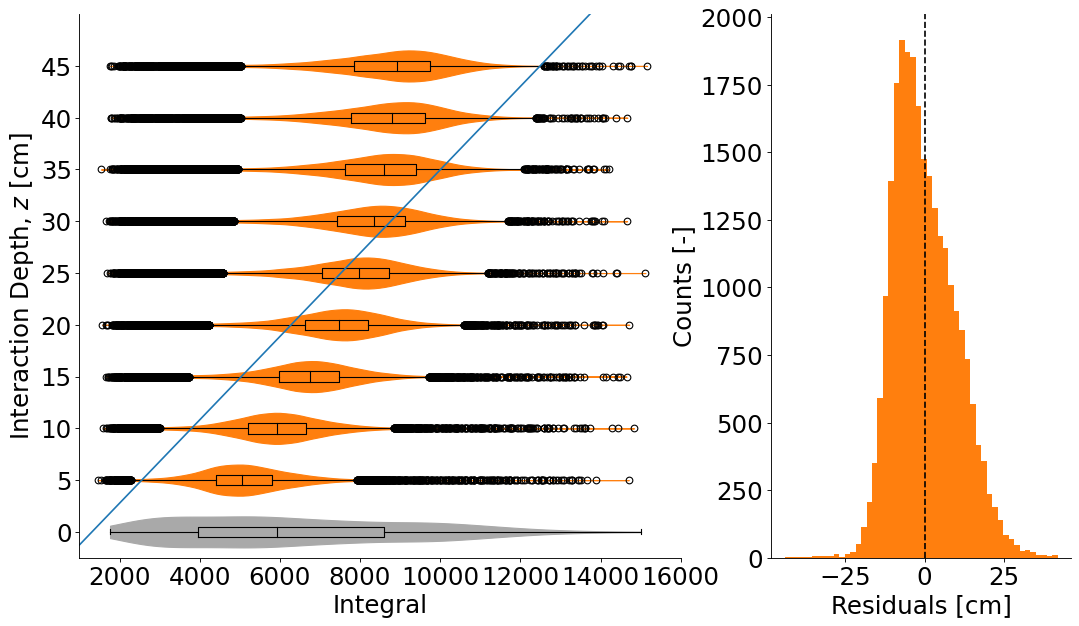

In [ ]:
feature = 'Integral' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1000#@param {type:"number"}
xmax =  16000#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  2.726+/-0.007
Intercept:  -17.06+/-0.12
r2 =  0.350+/-0.014
Max error =  47+/-12
MAE =  8.06+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


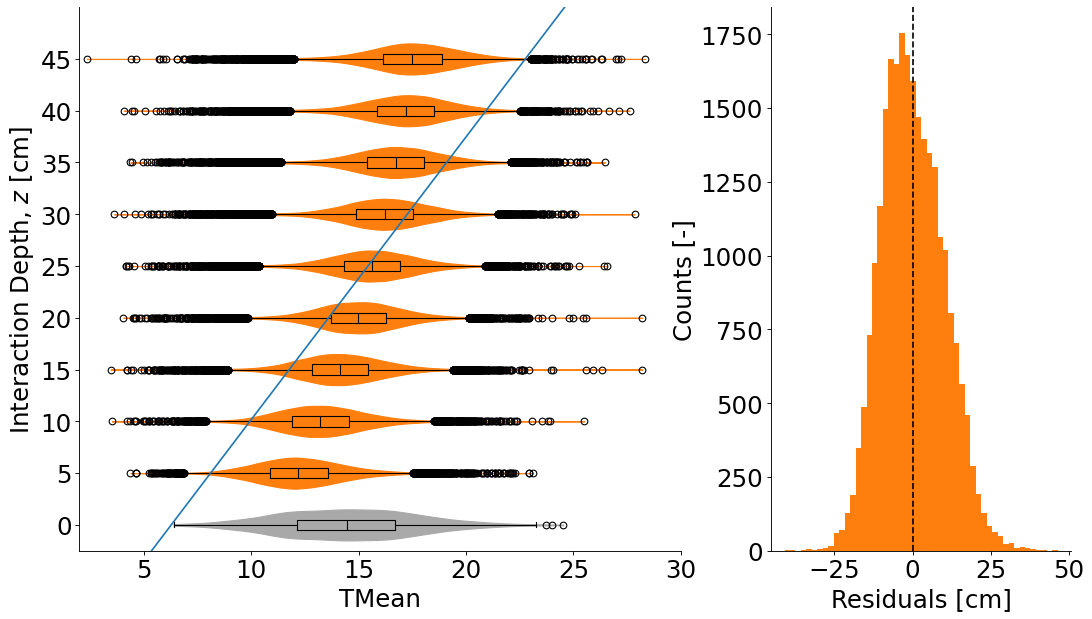

In [ ]:
feature = 'TMean' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  30#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  -4.445+/-0.013
Intercept:  82.90+/-0.18
r2 =  0.343+/-0.015
Max error =  49+/-8
MAE =  8.08+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


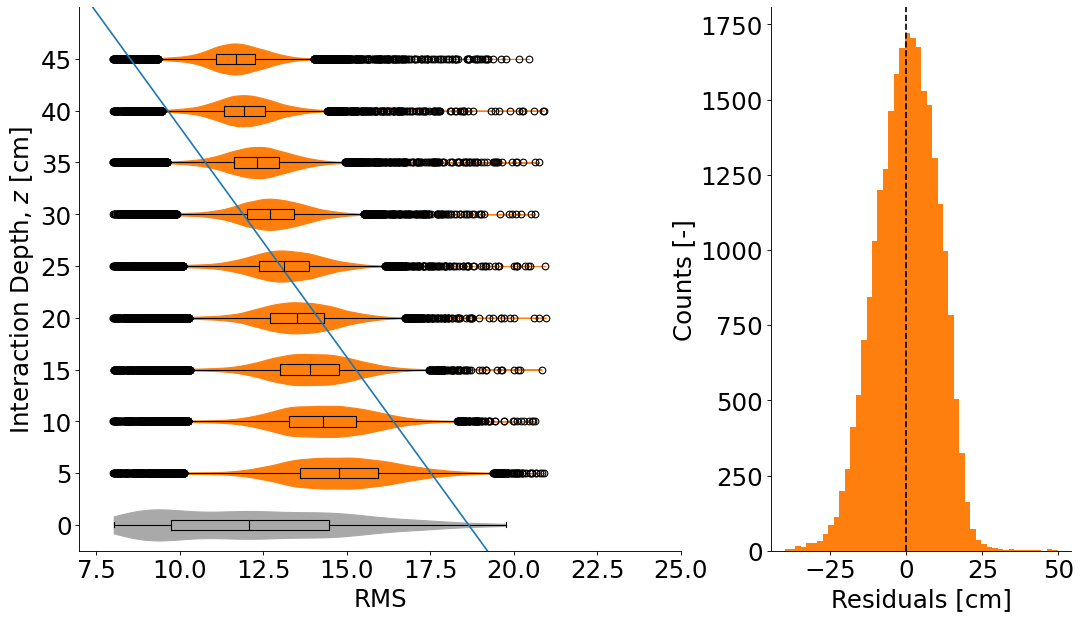

In [ ]:
feature = 'RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  7#@param {type:"number"}
xmax =  25#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  2.010+/-0.007
Intercept:  -12.98+/-0.13
r2 =  0.249+/-0.014
Max error =  41.0+/-3.3
MAE =  8.81+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


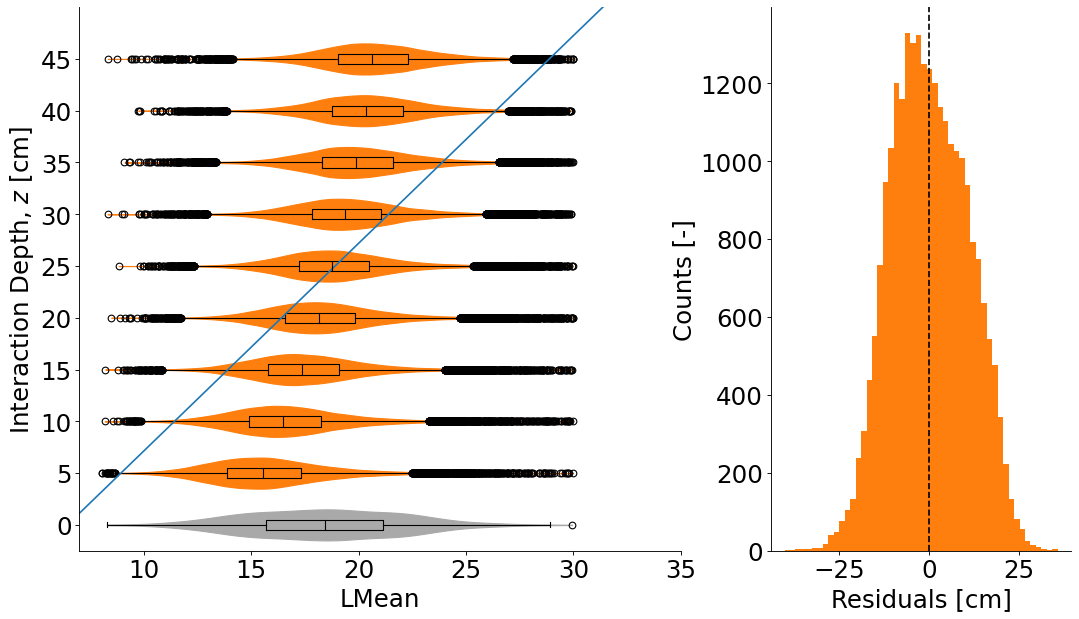

In [ ]:
feature = 'LMean' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  7#@param {type:"number"}
xmax =  35#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  1.268+/-0.006
Intercept:  0.61+/-0.11
r2 =  0.159+/-0.012
Max error =  36+/-4
MAE =  9.50+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


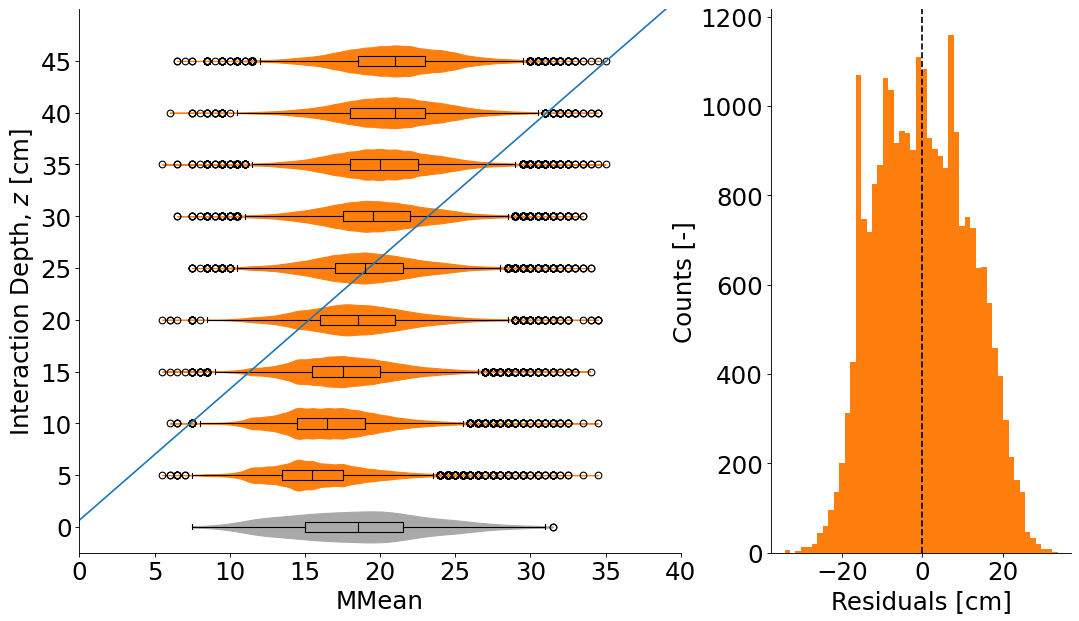

In [ ]:
feature = 'MMean' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax =  40#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

# Z-estimate


## Wrapper methods

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

fit_data = roi.loc[roi['z[cm]']>0] 
x = fit_data.drop(['z[cm]'], axis=1)
y = fit_data['z[cm]']

RFE_regressor = LinearRegression()#SVR(kernel='linear')#

for nfeat in range(1,6):
  print('For '+str(nfeat)+' features:')
  rfe = RFE(RFE_regressor, n_features_to_select=nfeat, step=1)
  rfe = rfe.fit(x,y)
  print(x.columns[rfe.support_])
  print(rfe.score(x,y))

For 1 features:
Index(['TSigma'], dtype='object')
0.5601060664685693
For 2 features:
Index(['TSigma', 'LSigma'], dtype='object')
0.6384074740235497
For 3 features:
Index(['TSigma', 'LSigma', 'eta'], dtype='object')
0.6384241291958714
For 4 features:
Index(['TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573803859312641
For 5 features:
Index(['Slim', 'TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573847455068815


"\nRFE_regressor = LinearRegression()\nrfe = RFE(RFE_regressor, n_features_to_select=5, step=1)\n\nrfe = rfe.fit(x,y)\n\nfor index in range(0, len(rfe.ranking_)):\n  print(x.columns[index], str('\t'), rfe.ranking_[index])\n  "